In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df=pd.read_csv('dataframes/owid-covid-data.csv')
df=df.drop(['total_deaths','new_deaths','iso_code','continent'],axis=1)
df=df[30:] #removing datas where there is no new cases 
df=df.reset_index()
# last_date= df['date'].tolist()
# x= len(df['date'])
# last_date[x-1]
df

,index,location,date,total_cases,new_cases
0,30,Nepal,2/24/2020,1,0
1,31,Nepal,2/25/2020,1,0
2,32,Nepal,2/26/2020,1,0
3,33,Nepal,2/27/2020,1,0
4,34,Nepal,2/28/2020,1,0
...,...,...,...,...,...
366,396,Nepal,2/24/2021,273760,94
367,397,Nepal,2/25/2021,273872,112
368,398,Nepal,2/26/2021,273984,112
369,399,Nepal,2/27/2021,274065,81


In [4]:
df1=df['new_cases']
df1

0        0
1        0
2        0
3        0
4        0
      ... 
366     94
367    112
368    112
369     81
370     78
Name: new_cases, Length: 371, dtype: int64

In [5]:
## LSTM are sensitive to the scale of the data. so we apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# df2=scaler.inverse_transform(df1)
# df1

In [6]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [8]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [476]:

# y_train

In [9]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_test.shape

(89, 3, 1)

In [10]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [11]:
time_step

3

In [33]:
model=Sequential()
model.add(LSTM(128,activation='relu',use_bias=True, bias_initializer='ones',return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=True,activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',optimizer=opt)


In [34]:
model.layers[0].get_weights()#weights and bias

[array([[-3.06623429e-02, -3.97216976e-02,  7.81343356e-02,
          6.69236407e-02, -3.26380730e-02, -1.03316858e-01,
         -7.35280663e-03, -8.74189436e-02, -7.02632964e-03,
          7.60208145e-02,  8.67686421e-03, -1.20858178e-02,
         -9.58895311e-02,  5.96317425e-02,  1.02909654e-02,
         -3.64443958e-02, -6.62106574e-02,  5.94746843e-02,
         -3.70541438e-02,  5.55501506e-02,  1.83604583e-02,
          1.05072848e-01, -8.90803039e-02,  5.22296876e-03,
          4.77169976e-02, -7.76588768e-02, -9.92130339e-02,
         -1.06543973e-02, -8.78945366e-02, -8.75431448e-02,
         -7.67891407e-02,  9.64048281e-02, -4.73481417e-03,
         -3.22976187e-02,  1.14938095e-02, -6.37377948e-02,
         -5.83255775e-02, -1.16344914e-02, -6.06435165e-02,
          3.05226967e-02, -4.85635512e-02, -5.91327585e-02,
         -9.63678807e-02, -9.95156914e-02,  3.53562906e-02,
         -8.77835825e-02,  5.60962334e-02,  6.66186139e-02,
          6.55117705e-02, -1.06672928e-0

In [482]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=16,verbose=0)

In [483]:
import tensorflow as tf

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [484]:
import math
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
math.sqrt(mean_squared_error(y_train,train_predict))


0.06713411360320115

In [485]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_train=scaler.inverse_transform(y_train.reshape(-1,1))
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
# y_train,train_predict

In [486]:
### Calculate RMSE performance metrics
import math
import statistics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict)) ,mean_absolute_percentage_error(y_train,train_predict)

(385.55122182210505, 8.566549394489962e+16)

In [487]:
math.sqrt(mean_squared_error(y_test, test_predict))


361.5094655461646

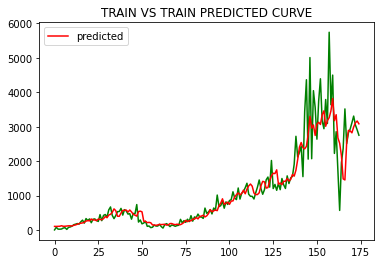

In [488]:
## Plotting 
plt.plot(y_train[80:],color='green')
plt.plot(train_predict[80:],color='red',label='predicted')
plt.title("TRAIN VS TRAIN PREDICTED CURVE")
plt.legend()

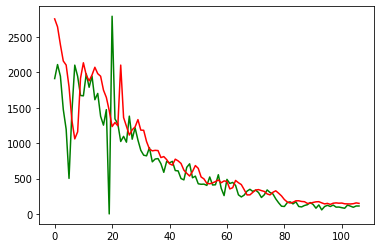

In [489]:
plt.plot(y_test,color='green')
plt.plot(test_predict,color='red')


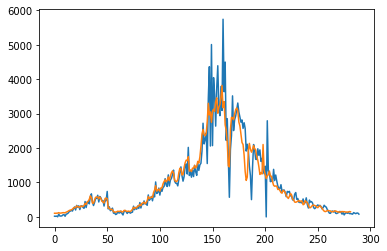

In [490]:
alll=scaler.inverse_transform(df1)
predicted= train_predict.tolist()+ test_predict.tolist()
plt.plot(alll[80:])
plt.plot(predicted[80:])
# alll.shape


In [491]:
# X_all=scaler.inverse_transform(X_train)
X_train.shape

(255, 3, 1)

In [492]:
data=alll[:len(predicted)]
len(data),len(predicted)
math.sqrt(mean_squared_error(data, predicted))
# mean_absolute_percentage_error(data,predicted)

352.7508187760594

In [493]:
len(test_data)

111

In [494]:
n_steps= time_step

n_steps

3

In [495]:
x_input=test_data[len(test_data)-n_steps:].reshape(1,-1)
x_input.shape

(1, 3)

In [496]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.019502002437750306, 0.019502002437750306, 0.014104126763015847]

In [497]:
time_step

3

In [498]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<1):
    
    if(len(temp_input)>3):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print("predicted cases for next day:")
print(scaler.inverse_transform(lst_output))

predicted cases for next day:
[[150.56515417]]


In [499]:
prev= df['new_cases'][len(df)-3:].tolist()
new=scaler.inverse_transform(np.array(lst_output[0][0]).reshape(-1,1))
new=math.floor(new[0][0])
new,prev

(150, [112, 112, 81])